# AE with CONV Layers

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets

from tqdm import tqdm

from constants import *
from PIL import Image

In [3]:
img = Image.open('../data/mona-lisa.jpg')
img = img.resize((256, 256))
X = torch.asarray(np.asarray(img)/255, dtype=torch.float, requires_grad=True).to(device)
X = X.reshape((1,3,256,256))
X.shape

torch.Size([1, 3, 256, 256])

In [20]:
X[0][0][0][:25]

tensor([0.3765, 0.4392, 0.3373, 0.3373, 0.3843, 0.2902, 0.3529, 0.3961, 0.3020,
        0.3647, 0.4235, 0.3255, 0.3216, 0.4157, 0.3137, 0.2784, 0.4157, 0.3059,
        0.2353, 0.4000, 0.2863, 0.2314, 0.4000, 0.2980, 0.2353],
       device='cuda:0', grad_fn=<SliceBackward0>)

(256, 256, 3)

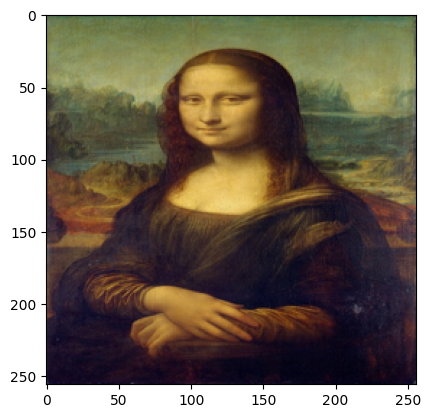

In [5]:
plt.imshow(np.array(img))
np.asarray(img).shape

In [6]:
R = nn.ReLU()
C1 = nn.Conv2d(3, 32, (3, 3)).to(device)
M1 = nn.MaxPool2d((2, 2)).to(device)
C2 = nn.Conv2d(32, 8, (3, 3)).to(device)
M2 = nn.MaxPool2d((2, 2)).to(device)
C3 = nn.Conv2d(8, 8, (3, 3)).to(device)
M3 = nn.MaxPool2d((2, 2)).to(device)

C4 = nn.Conv2d(8, 8, (3, 3)).to(device)
S1 = nn.Upsample(scale_factor=2).to(device)
C5 = nn.Conv2d(8, 8, (3, 3)).to(device)
S2 = nn.Upsample(scale_factor=3).to(device)
C6 = nn.Conv2d(8, 32, (3, 3)).to(device)
S3 = nn.Upsample((258, 258)).to(device)
C7 = nn.Conv2d(32, 3, (3, 3)).to(device)

c1 = R(C1(X))
m1 = M1(c1)
c2 = R(C2(m1))
m2 = M2(c2)
c3 = R(C3(m2))
m3 = M3(c3)

c4 = R(C4(m3))
s1 = S1(c4)
c5= R(C5(s1))
s2 = S2(c5)
c6= R(C6(s2))
s3 = S3(c6)
c7= R(C7(s3))

c7.shape

torch.Size([1, 3, 256, 256])

In [25]:
m1.shape, m2.shape, m3.shape, c4.shape

(torch.Size([1, 32, 127, 127]),
 torch.Size([1, 8, 62, 62]),
 torch.Size([1, 8, 30, 30]),
 torch.Size([1, 8, 28, 28]))

In [28]:
s1.shape, s2.shape, s3.shape

(torch.Size([1, 8, 56, 56]),
 torch.Size([1, 8, 162, 162]),
 torch.Size([1, 32, 258, 258]))

In [38]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.R = nn.ReLU()
        self.C1 = nn.Conv2d(3, 32, (3, 3)).to(device)
        self.M1 = nn.MaxPool2d((2, 2)).to(device)
        self.C2 = nn.Conv2d(32, 8, (3, 3)).to(device)
        self.M2 = nn.MaxPool2d((2, 2)).to(device)
        self.C3 = nn.Conv2d(8, 8, (3, 3)).to(device)
        self.M3 = nn.MaxPool2d((2, 2)).to(device)

        self.C4 = nn.Conv2d(8, 8, (3, 3)).to(device)
        self.S1 = nn.Upsample(scale_factor=2).to(device)
        self.C5 = nn.Conv2d(8, 8, (3, 3)).to(device)
        self.S2 = nn.Upsample(scale_factor=3).to(device)
        self.C6 = nn.Conv2d(8, 32, (3, 3)).to(device)
        self.S3 = nn.Upsample((258, 258)).to(device)
        self.C7 = nn.Conv2d(32, 3, (3, 3)).to(device)

    def forward(self, X):
        c1 = self.R(self.C1(X))
        m1 = self.M1(c1)
        c2 = self.R(self.C2(m1))
        m2 = self.M2(c2)
        c3 = self.R(self.C3(m2))
        m3 = self.M3(c3)

        c4 = self.R(C4(m3))
        s1 = self.S1(c4)
        c5= self.R(C5(s1))
        s2 = self.S2(c5)
        c6= self.R(C6(s2))
        s3 = self.S3(c6)
        c7= self.R(C7(s3))
        return c7

In [39]:
lr = 0.01
n_iters = 1000

In [40]:
m = AutoEncoder().to(device)
m.forward(X)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(m.parameters(), lr=lr)

for i in tqdm(range(1000)):
    logits = m.forward(X)
    loss = criterion(logits, X)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if(i%1000==0):
        print(loss)
print(loss)

  1%|          | 7/1000 [00:00<00:30, 32.26it/s]

tensor(0.1040, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 1000/1000 [00:04<00:00, 247.27it/s]

tensor(0.1039, device='cuda:0', grad_fn=<MseLossBackward0>)


## FIXME: Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


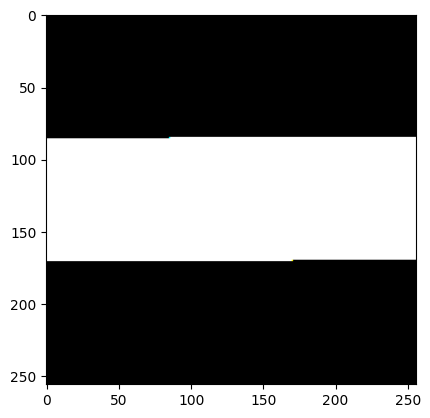

In [42]:
out = m.forward(X).reshape(1,256,256,3).cpu().detach().numpy()[0]
out =  np.array(out * 255)
plt.imshow(out)